In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import os 
import numpy as np
import random
import io
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
device = torch.device("cuda:0")
print(f"Using device: {device}")


Using device: cpu
Using device: cuda:0


In [2]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            self.conv_block(in_channels, 64),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            self.conv_block(256, 512),
            self.conv_block(512, 1024)
        )

        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            self.upconv_block(1024, 512),
            self.upconv_block(512, 256),
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder[0](x)
        enc2 = self.encoder[1](enc1)
        enc3 = self.encoder[2](enc2)
        enc4 = self.encoder[3](enc3)
        enc5 = self.encoder[4](enc4)

        # Decoder
        dec1 = self.decoder[0](enc5)
        dec2 = self.decoder[1](dec1 + enc4)
        dec3 = self.decoder[2](dec2 + enc3)
        dec4 = self.decoder[3](dec3 + enc2)
        out = self.decoder[4](dec4 + enc1)

        return out

In [3]:

path = "unet.pth"
model = torch.load(path, map_location=torch.device('cpu'))
model.eval()  # Set the model to evaluation mode if needed

UNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), strid

In [4]:
'''
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

with open('test_test.pt', 'rb') as f:
    w = CPU_Unpickler(f).load()

print(w)
model = torch.jit.load('face_reconstruction.pkl')

#model = model.to(device)'''


"\nclass CPU_Unpickler(pickle.Unpickler):\n    def find_class(self, module, name):\n        if module == 'torch.storage' and name == '_load_from_bytes':\n            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')\n        else: return super().find_class(module, name)\n\nwith open('test_test.pt', 'rb') as f:\n    w = CPU_Unpickler(f).load()\n\nprint(w)\nmodel = torch.jit.load('face_reconstruction.pkl')\n\n#model = model.to(device)"

In [5]:
def create_mask(images, mask_type="random"):
    """
    Generate a mask that blocks large contiguous regions of the face.
    
    mask_type:
    - "top" -> Blocks the top half of the image
    - "bottom" -> Blocks the bottom half of the image
    - "left" -> Blocks the left half of the image
    - "right" -> Blocks the right half of the image
    - "random" -> Blocks a random square region
    """
    batch_size, channels, height, width = images.size()
    mask = torch.ones(batch_size, channels, height, width, device=device)

    for i in range(batch_size):
        if mask_type == "top":
            mask[i, :, :height//2, :] = 0  # Mask top half
        elif mask_type == "bottom":
            mask[i, :, height//2:, :] = 0  # Mask bottom half
        elif mask_type == "left":
            mask[i, :, :, :width//2] = 0  # Mask left half
        elif mask_type == "right":
            mask[i, :, :, width//2:] = 0  # Mask right half
        elif mask_type == "random":
            # Create a random square mask
            size = random.randint(height//3, height//2)  # Random block size
            x = random.randint(0, height - size)
            y = random.randint(0, width - size)
            mask[i, :, x:x+size, y:y+size] = 0  # Apply random block mask

    return mask

In [6]:
# Load CelebA dataset with a subset of 10,000 images
dataset = datasets.CelebA(
    root="./data",
    split="train",
    download=True,
    transform=transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
)
subset_indices = list(range(10000))  # Select first 10,000 images
subset_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=8, shuffle=True)

Files already downloaded and verified


torch.Size([8, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


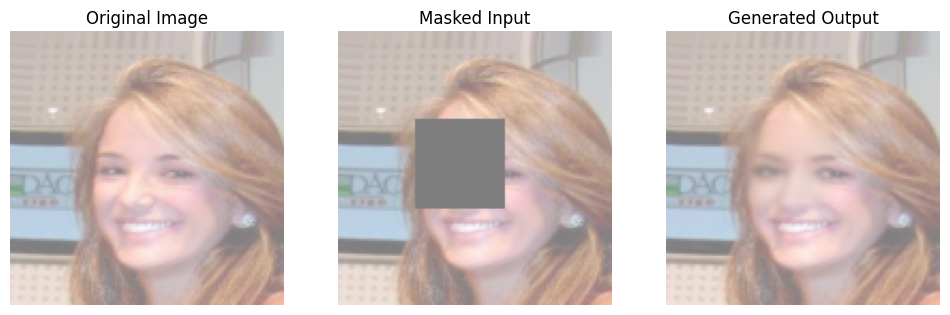

In [18]:
def show_example(model, dataloader, device, mask_type="random"):
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    mask = create_mask(imgs, mask_type=mask_type)
    masked_imgs = imgs * mask

    print(masked_imgs.shape)
    
    with torch.no_grad():
        generated_imgs = model(masked_imgs)

    def denorm(img):
        return (img * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

    idx = 0  # Select the first image from the batch
    original = denorm(imgs[idx].cpu().permute(1, 2, 0))
    masked = denorm(masked_imgs[idx].cpu().permute(1, 2, 0))
    generated = denorm(generated_imgs[idx].cpu().permute(1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(original.numpy())
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(masked.numpy())
    axes[1].set_title("Masked Input")
    axes[1].axis("off")

    axes[2].imshow(generated.numpy())
    axes[2].set_title("Generated Output")
    axes[2].axis("off")

    plt.show()

device = torch.device("cpu")
# Run the function to visualize an example
show_example(model, dataloader, "cpu", mask_type="random") 

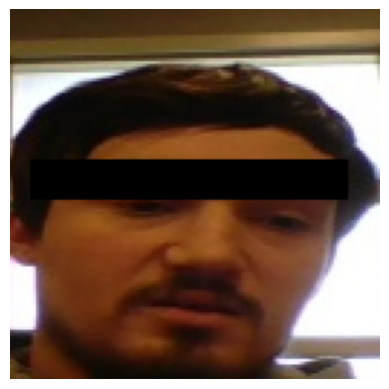

In [ ]:
import torch
import torchvision.transforms.functional as F
from PIL import Image
import random

def add_random_mask(image_path, mask_ratio=0.5, mask_color=(0, 0, 0)):
    """
    Adds a random rectangular mask to an image.

    Args:
        image_path (str): Path to the image file.
        mask_ratio (float): Ratio of the image area to be masked (0 to 1).
        mask_color (tuple): RGB color of the mask.
    
    Returns:
        torch.Tensor: Image with the mask applied.
    """
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)

    height, width = image_tensor.shape[1], image_tensor.shape[2]
    mask_area = int(height * width * mask_ratio)

    mask_width = random.randint(1, width)
    mask_height = mask_area // mask_width
    
    if mask_height > height:
        mask_height = height
        mask_width = mask_area // mask_height
    
    x_start = random.randint(0, width - mask_width) if width > mask_width else 0
    y_start = random.randint(0, height - mask_height) if height > mask_height else 0

    mask = torch.ones_like(image_tensor[:, y_start:y_start+mask_height, x_start:x_start+mask_width])
    mask[0, :, :] *= mask_color[0] / 255.0
    mask[1, :, :] *= mask_color[1] / 255.0
    mask[2, :, :] *= mask_color[2] / 255.0

    image_tensor[:, y_start:y_start+mask_height, x_start:x_start+mask_width] = mask
    return image_tensor


image_path = "D:/hackpsuS25/hackpsu_S25/face/output_image_1.jpg"
masked_image = add_random_mask(image_path, mask_ratio=0.1, mask_color=(0, 0, 0))


def show_tensor_image(tensor):
    """
    Displays a PyTorch tensor as an image using Matplotlib.

    Args:
        tensor (torch.Tensor): The tensor to display. 
                              It can be a single image (C, H, W) or a batch of images (B, C, H, W).
    """
    # Handle batch of images
    if tensor.ndim == 4:
      tensor = tensor[0] # Take the first image in the batch

    # Check if the tensor has a channel dimension
    if tensor.ndim == 3:
        # Transpose the tensor to (H, W, C) if it's in (C, H, W) format
        tensor = tensor.permute(1, 2, 0)
    elif tensor.ndim == 2:
        # Add a channel dimension for grayscale images (H, W) -> (H, W, 1)
        tensor = tensor.unsqueeze(-1)
    else:
        raise ValueError("Tensor must have 2 or 3 dimensions (H, W) or (C, H, W)")
    
    # Convert the tensor to a NumPy array and display it
    plt.imshow(tensor.numpy())
    plt.axis('off')  # Hide axes
    plt.show()

show_tensor_image(masked_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 128, 128])


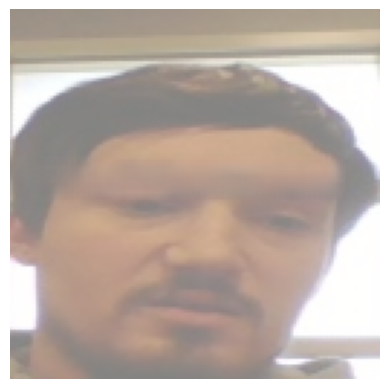

In [38]:

masked_image = masked_image.unsqueeze(0)  # Add batch dimension
masked_image = masked_image.to(device)
print(masked_image.shape)  # Should be (3, H, W) for a single image

with torch.no_grad():
        generated_imgs = model(masked_image)
def denorm(img):
    return (img * 0.5) + 0.5
idx = 0

plt.imshow(denorm(generated_imgs[idx].cpu().permute(1, 2, 0)))
plt.axis('off')  # Hide axes
plt.show()